In [1]:
import numpy as np
import pandas as pd
from time import time

from sklearn.metrics import precision_recall_curve, roc_auc_score
from torchmetrics.classification import BinaryF1Score, AUROC

import torch
from torch import nn

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = 'mps'
batch_size = 128

In [3]:
df = pd.read_csv('/Users/le_fuu/GitHub_Local/Phase_2/project_3/nlp_project/data/labeled.csv')

In [4]:
df

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0


In [5]:
# Проверка средней длинны предложения в датасете

# test = df['comment'].apply(lambda x: len(x.split()))
# test.describe()

In [6]:
model_checkpoint = 'cointegrated/rubert-tiny-toxicity'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
def text2toxicity(text, aggregate=True):
    """ Calculate toxicity of a text (if aggregate=True) or a vector of toxicity aspects (if aggregate=False)"""
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()
    if isinstance(text, str):
        proba = proba[0]
    if aggregate:
        return 1 - proba.T[0] * (1 - proba.T[-1])
    return proba

# print(text2toxicity('я люблю нигеров', True))
# # 0.9350118728093193

# print(text2toxicity('я люблю нигеров', False))
# # [0.9715758  0.0180863  0.0045551  0.00189755 0.9331106 ]

# print(text2toxicity(['я люблю нигеров', 'я люблю африканцев'], True))
# # [0.93501186 0.04156357]

# print(text2toxicity(['я люблю нигеров', 'я люблю африканцев'], False))
# # [[9.7157580e-01 1.8086294e-02 4.5550885e-03 1.8975559e-03 9.3311059e-01]
# #  [9.9979788e-01 1.9048342e-04 1.5297388e-04 1.7452303e-04 4.1369814e-02]]


In [7]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-1

In [8]:
def tokenize_texts(texts):
    return tokenizer(texts, padding='max_length', max_length=50, truncation=True, return_tensors="pt")

In [9]:
encodings = tokenize_texts(df["comment"].tolist())
labels = torch.tensor(df["toxic"].tolist())

In [10]:
class ToxicityDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

dataset = ToxicityDataset(encodings, labels)

In [11]:
train_ds, valid_ds = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(train_ds, shuffle=False, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_ds, shuffle=False, batch_size=batch_size)

In [12]:
batch = next(iter(train_loader))
batch["input_ids"].shape, batch["labels"].shape

(torch.Size([128, 50]), torch.Size([128]))

In [21]:
class ToxicBert(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained('cointegrated/rubert-tiny-toxicity')
        for param in self.bert.parameters():
            param.requires_grad = False
        self.bert.classifier = nn.Linear(312, 1)
        for param in self.bert.classifier.parameters():
            param.requires_grad = True
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits

In [22]:
model = ToxicBert()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
metric = AUROC(task='binary').to(device)
# for params in model.parameters():
#     print(params.requires_grad)

In [23]:
def train(
        epochs: int, 
        model: torch.nn.Module, 
        train_loader: torch.utils.data.DataLoader,
        valid_loader: torch.utils.data.DataLoader, 
        optimizer: torch.optim.Optimizer, 
        criterion, 
        metric
        ) -> tuple: 
    """Training recurrent model for binary classification task

    Args:
        epochs (int): Number of epochs
        model (nn.Module): Model instance
        train_loader (Dataloader): train loader
        valid_loader (Dataloader): valid loader
        optimizer (nn.Module): optimizer
        criterion (nn.Module): criterion
        metric (_type_): metric from torchmetrics
        rnn_conf (dataclass): dataclass with params

    Returns:
        tuple: (train loss, valid loss, train metric, valid metric, training_time)
    """
    epoch_train_losses = []
    epoch_valid_losses = []
    epoch_train_metric = []
    epoch_valid_metric = []
    time_start = time()
    for epoch in range(epochs):
        batch_losses = []
        batch_metric = []
        model.train()
        for batch in train_loader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            labels = labels.unsqueeze(1)

            outputs = model(input_ids, attention_mask)

            loss = criterion(outputs, labels)

            preds = torch.sigmoid(outputs)
            score = metric(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            batch_metric.append(score.item())
        
        epoch_train_losses.append(np.mean(batch_losses))
        epoch_train_metric.append(np.mean(batch_metric))

        # Валидация
        batch_losses = []
        batch_metric = []
        model.eval()
        with torch.no_grad():
            for batch in valid_loader:
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                labels = labels.unsqueeze(1)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

                preds = torch.sigmoid(outputs)
                score = metric(preds, labels)
                
                batch_losses.append(loss.item())
                batch_metric.append(score.item())

        epoch_valid_losses.append(np.mean(batch_losses))
        epoch_valid_metric.append(np.mean(batch_metric))

        print(f'Epoch {epoch+1}') 
        print(f'train_loss : {epoch_train_losses[-1]:.4f} val_loss : {epoch_valid_losses[-1]:.4f}')
        print(f'train_metric : {epoch_train_metric[-1]:.2f} val_metric : {epoch_valid_metric[-1]:.2f}')
        print(25*'==')

    training_time = time() - time_start
    return (epoch_train_losses, epoch_valid_losses, epoch_train_metric, epoch_valid_metric, training_time)

In [24]:
epoch_train_losses, epoch_valid_losses, epoch_train_metric, epoch_valid_metric, training_time = train(epochs=50, model=model, train_loader=train_loader, valid_loader=valid_loader, optimizer=optimizer, criterion=criterion, metric=metric)

Epoch 1
train_loss : 0.4141 val_loss : 0.3864
train_metric : 0.88 val_metric : 0.90
Epoch 2
train_loss : 0.3812 val_loss : 0.3746
train_metric : 0.90 val_metric : 0.90
Epoch 3
train_loss : 0.3712 val_loss : 0.3670
train_metric : 0.90 val_metric : 0.91
Epoch 4
train_loss : 0.3670 val_loss : 0.3625
train_metric : 0.90 val_metric : 0.91
Epoch 5
train_loss : 0.3645 val_loss : 0.3591
train_metric : 0.90 val_metric : 0.91
Epoch 6
train_loss : 0.3600 val_loss : 0.3561
train_metric : 0.91 val_metric : 0.91
Epoch 7
train_loss : 0.3578 val_loss : 0.3550
train_metric : 0.91 val_metric : 0.91
Epoch 8
train_loss : 0.3549 val_loss : 0.3526
train_metric : 0.91 val_metric : 0.91
Epoch 9
train_loss : 0.3551 val_loss : 0.3517
train_metric : 0.91 val_metric : 0.91
Epoch 10
train_loss : 0.3564 val_loss : 0.3505
train_metric : 0.91 val_metric : 0.91
Epoch 11
train_loss : 0.3546 val_loss : 0.3486
train_metric : 0.91 val_metric : 0.91
Epoch 12
train_loss : 0.3540 val_loss : 0.3484
train_metric : 0.91 val_met

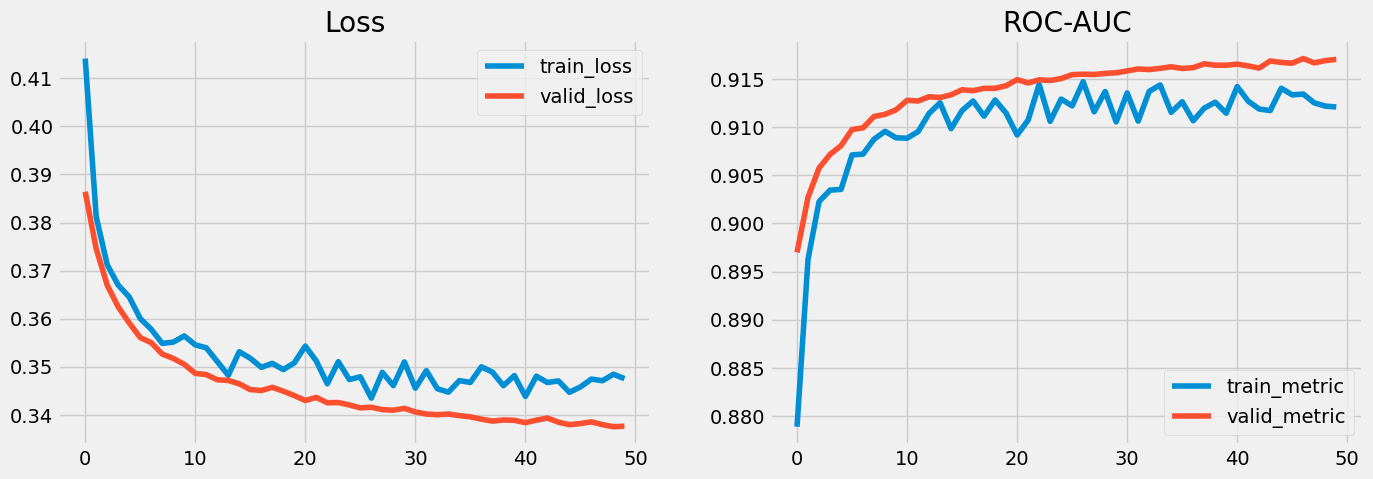

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(epoch_train_losses, label='train_loss')
ax[0].plot(epoch_valid_losses, label='valid_loss')
ax[0].legend()
ax[0].set_title('Loss')
ax[1].plot(epoch_train_metric, label='train_metric')
ax[1].plot(epoch_valid_metric, label='valid_metric')
ax[1].legend()
ax[1].set_title('ROC-AUC')
plt.legend()
plt.show()
# plt.savefig('/Users/le_fuu/GitHub_Local/Phase_2/project_3/nlp_project/images/loss_ROCAUC.png')


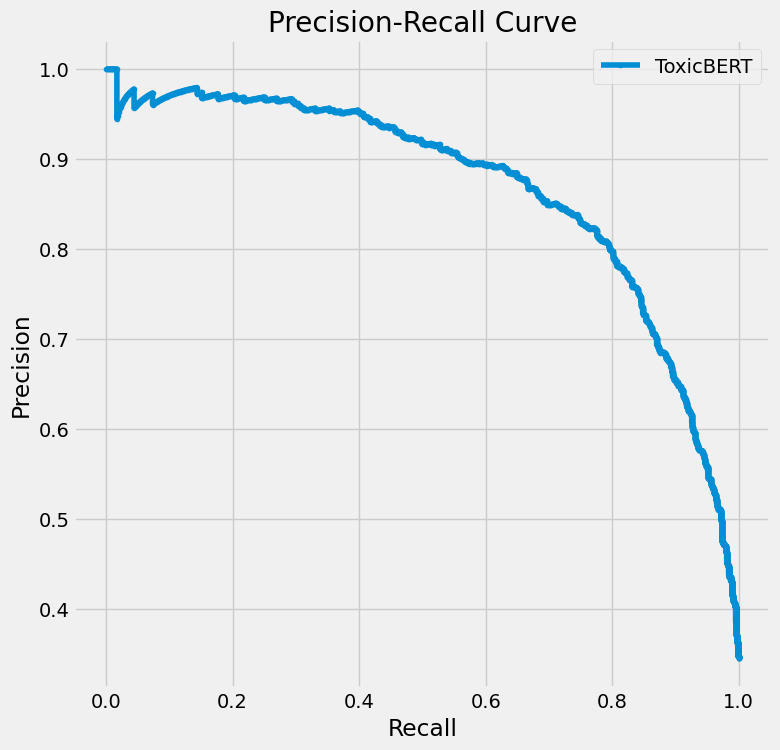

In [ ]:
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in valid_loader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        
        probs = torch.sigmoid(outputs) 

        all_labels.extend(labels.cpu().numpy()) 
        all_probs.extend(probs.cpu().numpy())

# Преобразовать в numpy
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Получаем Precision-Recall
precision, recall, _ = precision_recall_curve(all_labels, all_probs)

# Построить график
plt.figure(figsize=(8,8))
plt.plot(recall, precision, marker='.', label='ToxicBERT')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
plt.savefig('/Users/le_fuu/GitHub_Local/Phase_2/project_3/nlp_project/images/pr_curve.png')

In [ ]:
torch.save(model.state_dict(), '/Users/le_fuu/GitHub_Local/Phase_2/project_3/nlp_project/models/model_2/toxic_bert_v1.pth')

### TEST

In [119]:
n = 9994

In [120]:
test = df['comment'][n]

In [121]:
test_tok = tokenize_texts(test)
test_tok['input_ids']
test_tok['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])

In [122]:
logits = model(test_tok['input_ids'].to(device), test_tok['attention_mask'].to(device)).item()
prob = torch.sigmoid(torch.tensor(logits)).item()

In [123]:
print(df['comment'][n])
print(prob)

но зачем, если этот наверняка справляется и скорее всего проще в обслуживании ?

0.02621011808514595
